In [83]:
#import emnist
from keras.datasets import mnist

from keras.layers import (Input, Dense, Reshape, Flatten, BatchNormalization, Conv2DTranspose,
                         SeparableConv2D, UpSampling2D, Dropout, Conv2D, UpSampling2D, Dropout, LeakyReLU)
from keras.layers import Activation
#from keras.layers.advanced_activations import LeakyReLU
import keras
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

In [84]:
def gen_fake(gen, batch_size, normal_noise=True):
    fake = gen.predict(gen_noise(batch_size, normal=normal_noise))
    return fake

def sample_real(real, batch_size):
    real = real[np.random.randint(0, len(real), size=batch_size)]
    return real

def gen_noise(batch_size, normal=True):
    if normal:
        return np.random.normal(size=(batch_size, z_dim))
    else:
        return np.random.uniform(-1, 1, (batch_size, z_dim))

def get_training_set(real=[], fake=[]):
    if len(real) == 0:
        x_batch = fake
    elif len(fake) == 0:
        x_batch = real
    else:
        x_batch = np.concatenate([fake, real])
    y_batch = np.concatenate([np.zeros(len(fake)), np.ones(len(real))])
    return x_batch, y_batch

In [85]:
def get_history_summary(histories):
    fields = ["acc", "loss", "val_acc", "val_loss"]
    history = {}
    
    for field in fields:
        vals = [history.history.get(field, 0)[-1] for history in histories]
        history[field] = np.round(np.median(vals),4)
    
    lens = np.median([len(history.history.get(fields[0])) for history in histories])
    history["num_epochs"] = lens
    
    return history

def display_gen(gan, n_samples, real=None, fname=None, show=True, num_cols=15):
    gen, disc = gan.layers[1:3]
    
    if real is not None:
        n_real = n_samples // 2
        n_fake = n_samples // 2  + n_samples % 2 # add 1 if n_samples is odd
    else:
        n_real = 0
        n_fake = n_samples
    
    # Fake
    noise = gen_noise(n_fake)    
    fake_samples = gen.predict(noise)
    
    # Real
    if n_real > 0:
        real_samples = sample_real(real, n_real)
        samples = np.concatenate([fake_samples, real_samples])
        is_reals = np.concatenate([np.repeat(False, n_fake), np.repeat(True, n_real)])
    else:
        samples = fake_samples
        is_reals = np.repeat(False, n_fake)
        
    disc_out = disc.predict(samples)
    
    ims = (samples + 1) / 127.5 
    ims = ims.squeeze(axis=-1)
    
    predicts = np.round(disc_out,2).squeeze()
    
    examples = sorted(zip(ims,is_reals,predicts),key=lambda x: x[2])
    
    ncols = min(n_samples, num_cols)
    nrows = (n_samples - 1) // ncols + 1
    
    f, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True)
    f.set_size_inches(ncols * 2, nrows * 2.5)
    
    plt.xticks([])
    plt.yticks([])
    
    if n_samples == 1:
        axes = [axes]
        
    for ax, (ex, is_real, predict) in zip(axes.ravel(), examples):
        ax.imshow(ex)
        if is_real:
            color="xkcd:dark green"
        else:
            color="xkcd:bright red"
        ax.set_title(predict, color=color,fontsize=30)
    
    plt.tight_layout()
    if fname:
        plt.savefig(fname=fname)
        plt.close()
    else:
        plt.show()

In [86]:
def generator(img_shape, z_dim):
    inp = Input(shape=(z_dim,), name="noise")
    
    # Dense
    x = Dense(7 * 7 * 256, name="gen_dense")(inp)
    x = LeakyReLU(alpha=0.01, name="gen_act")(x)
    x = BatchNormalization(name="gen_batch_norm")(x)
    
    x = Reshape([7,7,256], name="gen_reshape")(x)
    x = Dropout(0.4)(x)
    x = UpSampling2D(name="gen_up_sample")(x)

    # Transposed Convolution
    x = Conv2DTranspose(128, 5, padding="same", name="gen_conv_1")(x)
    x = LeakyReLU(alpha=0.01, name="gen_act_1")(x)
    x = BatchNormalization(name="gen_batch_norm_1")(x)
    x = UpSampling2D(name="gen_up_sample_1")(x)

    # Transposed Convolution
    x = Conv2DTranspose(64, 5, padding="same", name="gen_conv_2")(x)
    x = LeakyReLU(alpha=0.01, name="gen_act_2")(x)
    x = BatchNormalization(name="gen_batch_norm_2")(x)

    # Transposed Convolution
    x = Conv2DTranspose(32, 5, padding="same", name="gen_conv_3")(x)
    x = LeakyReLU(alpha=0.01, name="gen_act_3")(x)
    x = BatchNormalization(name="gen_batch_norm_3")(x)
    
    out = Conv2DTranspose(1, 5, padding="same", name="gen_conv_4", activation="tanh")(x)
    
    return Model(inp, out, name="generator")

def discriminator(img_shape):
    inp = Input(shape=[*img_shape, 1], name="image")
    
    x = Reshape([*img_shape, 1], name="disc_reshape")(inp)
    
    x = Conv2D(64, 5, strides=2, padding="same", name="disc_conv_1")(x)
    x = LeakyReLU(alpha=0.01, name="disc_act_1")(x)
#     x = BatchNormalization(name="disc_batch_norm_1")(x)
    x = Dropout(0.4)(x)
    
    x = Conv2D(128, 5, strides=2, padding="same", name="disc_conv_2")(x)
    x = LeakyReLU(alpha=0.01, name="disc_act_2")(x)
#     x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    x = Conv2D(256, 5, strides=2, padding="same", name="disc_conv_3")(x)
    x = LeakyReLU(alpha=0.01, name="disc_act_3")(x)
#     x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    x = Conv2D(512, 5, strides=1, padding="same", name="disc_conv_4")(x)
    x = LeakyReLU(alpha=0.01, name="disc_act_4")(x)
#     x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Flatten()(x)

    out = Dense(1, activation="sigmoid", name="disc_out")(x)

    return Model(inp, out, name="discriminator")

def generative_adversarial_model(img_shape, z_dim):
    gen = generator(img_shape, z_dim)
    disc = discriminator(img_shape)
    
    inp = Input(shape=(*gen.input_shape[1:],), name="image")
    img = gen(inp)

    # NOTE: When creating our gan, we do not want the discriminator to be trainable
    disc.trainable = False 

    prediction = disc(img)

    gan = Model(inp, prediction, name="gan")
    gan.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    return gan

In [87]:
digit_size = 28
original_dim = (digit_size, digit_size)
batch_size = 1000

z_dim = 100

## Create the network

In [88]:
gan = generative_adversarial_model(img_shape=original_dim, z_dim=z_dim)
gan.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
gan.summary()

gan.layers[1].summary() # generator
gan.layers[2].summary() # discriminator

Model: "gan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 100)]             0         
                                                                 
 generator (Functional)      (None, 28, 28, 1)         2394241   
                                                                 
 discriminator (Functional)  (None, 1)                 4311553   
                                                                 
Total params: 6705794 (25.58 MB)
Trainable params: 2368705 (9.04 MB)
Non-trainable params: 4337089 (16.54 MB)
_________________________________________________________________
Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 noise (InputLayer)          [(None, 100)]             0         
                                                                 


In [89]:
def train(gan,
          num_iters,
          batch_size=128, 
          print_every=1,
          epochs=1,
          min_disc_acc = 0.5,
          min_gan_acc = 0.2,
          normal_noise=True,
          save_example_name=None,
          save_model_name=None,
          validation_split=0.2,
          callbacks=[]
         ):

    gen_history = History()
    disc_history = History()
    
    gen, disc = gan.layers[1:3]
    
    disc.trainable = True
    disc.compile(loss = gan.loss, optimizer = gan.optimizer, metrics= gan.metrics)
        
    if type(print_every) is int:
        print_every = np.arange(print_every, num_iters, print_every)
    print_every = set(print_every)
    
    actual_batch_size = int(batch_size / (1.0 - validation_split))
    
    for n in range(1, num_iters + 1):
        # Training the generator
        print("\rIteration: {}/{}".format(n, num_iters), end="")
        for epoch in range(1, epochs + 1):
            noise = gen_noise(actual_batch_size, normal=normal_noise)
            x_batch, y_batch = get_training_set(real=noise)
            h = gan.fit(x_batch, y_batch, epochs=1, verbose=0, validation_split=validation_split, callbacks=callbacks)
            print(h.params, "/n")
            gen_history.update(h)
            print(gen_history)
            print("Gen:",gen_history.get_latest("val_accuracy"))
            g_val_loss.append(gen_history.get_latest("val_loss"))
            
            gan_epochs = epoch
            
            if gen_history.get_latest("val_accuracy") > min_gan_acc:
                break

        # Training the discriminator
        for epoch in range(1, epochs + 1):
            fake = gen_fake(gen, actual_batch_size // 2)
            real = sample_real(X_train, actual_batch_size // 2)
            x_batch, y_batch = get_training_set(real=real, fake=fake)
            x_batch = x_batch.reshape([-1, *disc.input_shape[1:]])
            h = disc.fit(x_batch, y_batch, epochs=1, verbose=0, validation_split=validation_split, callbacks=callbacks)
            disc_history.update(h)
            print("DISC: ",disc_history)
            #print("Disc:",disc_history.get_latest("val_accuracy"))
            d_val_loss.append(disc_history.get_latest("val_loss"))
            disc_epochs = epoch
            if disc_history.get_latest("val_loss") > min_disc_acc:
                break


        if n in print_every:
            print("""\nGen status:  {}. \nDisc status: {}""".format(gen_history, disc_history))

            if save_model_name:
                gan.save("{:05}_{}.h5".format(n, save_model_name))
            
            display_gen(gan, 10)

            if save_example_name:
                fname = "{:05}_{}.png".format(n, save_example_name)
                display_gen(gan, 15 * 15, real=X_train, fname=fname)

            gen_hists = []
            disc_hists = []
            
    return gen_history, disc_history 

In [90]:
class History:
    def __init__(self):
        self.history = []
        
    def update(self, history):
        self.history.append(history.history)
    
    def __str__(self):
        latest = self.history[-1]
        str_val = " ".join(["{}: {:.5f}".format(k, v[-1]) for k, v in self.history[-1].items()])
        str_val += " epochs: {}".format(len(self.history))
        return str_val
    
    def get_latest(self, val):
        return self.history[-1].get(val)[-1]


In [91]:
(X_train, _), (X_test, _) = mnist.load_data()
# (X_train, _), (X_test, _) = mnist.load_data()

X_train = X_train / 127.5 - 1
X_test = X_test / 127.5 - 1

X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)


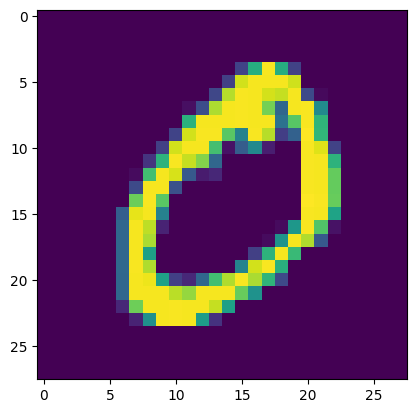

In [92]:
%matplotlib inline
plt.imshow(X_train[1].squeeze())

## Normal noise

Iteration: 1/50{'verbose': 0, 'epochs': 1, 'steps': 4} /n
loss: 0.70018 accuracy: 0.33594 val_loss: 0.69433 val_accuracy: 0.00000 epochs: 1
Gen: 0.0
{'verbose': 0, 'epochs': 1, 'steps': 4} /n
loss: 0.70039 accuracy: 0.35156 val_loss: 0.69369 val_accuracy: 0.15625 epochs: 2
Gen: 0.15625
{'verbose': 0, 'epochs': 1, 'steps': 4} /n
loss: 0.70307 accuracy: 0.25000 val_loss: 0.69460 val_accuracy: 0.09375 epochs: 3
Gen: 0.09375
{'verbose': 0, 'epochs': 1, 'steps': 4} /n
loss: 0.70271 accuracy: 0.26562 val_loss: 0.69392 val_accuracy: 0.28125 epochs: 4
Gen: 0.28125
3/3 [==============================] - 0s 93ms/step
DISC:  loss: 0.66005 val_loss: 0.25117 epochs: 1
3/3 [==============================] - 0s 94ms/step
DISC:  loss: 0.37212 val_loss: 0.00066 epochs: 2
3/3 [==============================] - 0s 95ms/step
DISC:  loss: 0.02115 val_loss: 0.47390 epochs: 3
3/3 [==============================] - 0s 95ms/step
DISC:  loss: 0.12824 val_loss: 0.00000 epochs: 4
3/3 [============================

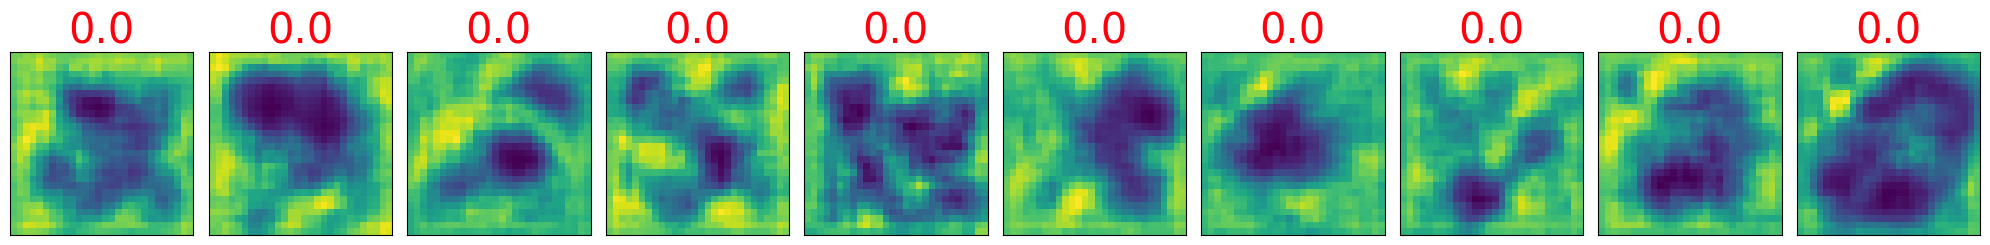

8/8 [==============================] - 0s 14ms/step
Iteration: 2/50{'verbose': 0, 'epochs': 1, 'steps': 4} /n
loss: 15.94158 accuracy: 0.51562 val_loss: 30.21634 val_accuracy: 0.00000 epochs: 5
Gen: 0.0
{'verbose': 0, 'epochs': 1, 'steps': 4} /n
loss: 3.55731 accuracy: 0.82812 val_loss: 38.01757 val_accuracy: 0.00000 epochs: 6
Gen: 0.0
{'verbose': 0, 'epochs': 1, 'steps': 4} /n
loss: 2.37472 accuracy: 0.88281 val_loss: 7.31079 val_accuracy: 0.37500 epochs: 7
Gen: 0.375
3/3 [==============================] - 0s 95ms/step
DISC:  loss: 1.09628 val_loss: 0.01193 epochs: 6
3/3 [==============================] - 0s 94ms/step
DISC:  loss: 0.12131 val_loss: 0.00005 epochs: 7
3/3 [==============================] - 0s 95ms/step
DISC:  loss: 0.08837 val_loss: 0.15385 epochs: 8
3/3 [==============================] - 0s 95ms/step
DISC:  loss: 0.12981 val_loss: 0.00753 epochs: 9
3/3 [==============================] - 0s 96ms/step
DISC:  loss: 0.03207 val_loss: 0.00010 epochs: 10

Gen status:  loss: 

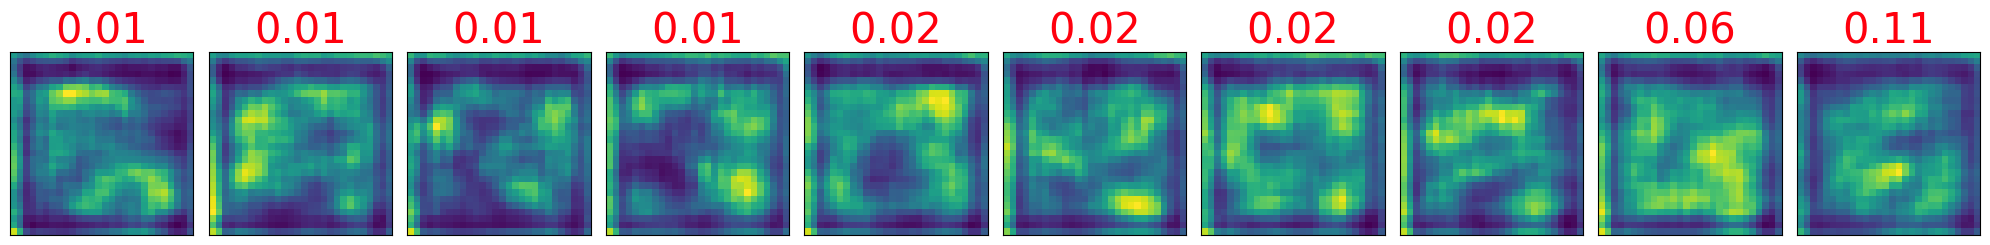

8/8 [==============================] - 0s 14ms/step
Iteration: 3/50{'verbose': 0, 'epochs': 1, 'steps': 4} /n
loss: 0.31046 accuracy: 0.91406 val_loss: 0.00000 val_accuracy: 1.00000 epochs: 8
Gen: 1.0
3/3 [==============================] - 0s 97ms/step
DISC:  loss: 4.47833 val_loss: 2.35343 epochs: 11

Gen status:  loss: 0.31046 accuracy: 0.91406 val_loss: 0.00000 val_accuracy: 1.00000 epochs: 8. 
Disc status: loss: 4.47833 val_loss: 2.35343 epochs: 11
1/1 [==============================] - 0s 18ms/step


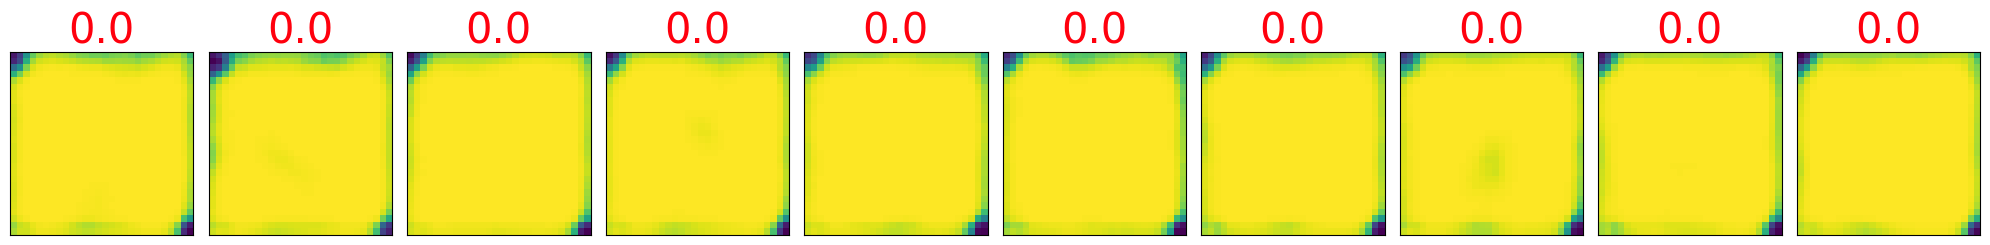

8/8 [==============================] - 0s 14ms/step
Iteration: 4/50{'verbose': 0, 'epochs': 1, 'steps': 4} /n
loss: 9.47410 accuracy: 0.00000 val_loss: 18.99327 val_accuracy: 0.00000 epochs: 9
Gen: 0.0
{'verbose': 0, 'epochs': 1, 'steps': 4} /n
loss: 7.84225 accuracy: 0.00000 val_loss: 19.00500 val_accuracy: 0.00000 epochs: 10
Gen: 0.0
{'verbose': 0, 'epochs': 1, 'steps': 4} /n
loss: 6.13049 accuracy: 0.02344 val_loss: 19.00951 val_accuracy: 0.00000 epochs: 11
Gen: 0.0
{'verbose': 0, 'epochs': 1, 'steps': 4} /n
loss: 5.43511 accuracy: 0.03906 val_loss: 19.01749 val_accuracy: 0.00000 epochs: 12
Gen: 0.0
{'verbose': 0, 'epochs': 1, 'steps': 4} /n
loss: 5.16006 accuracy: 0.00781 val_loss: 19.01585 val_accuracy: 0.00000 epochs: 13
Gen: 0.0
3/3 [==============================] - 0s 95ms/step
DISC:  loss: 0.49110 val_loss: 0.10617 epochs: 12
3/3 [==============================] - 0s 104ms/step
DISC:  loss: 0.01582 val_loss: 0.03465 epochs: 13
3/3 [==============================] - 0s 95ms/st

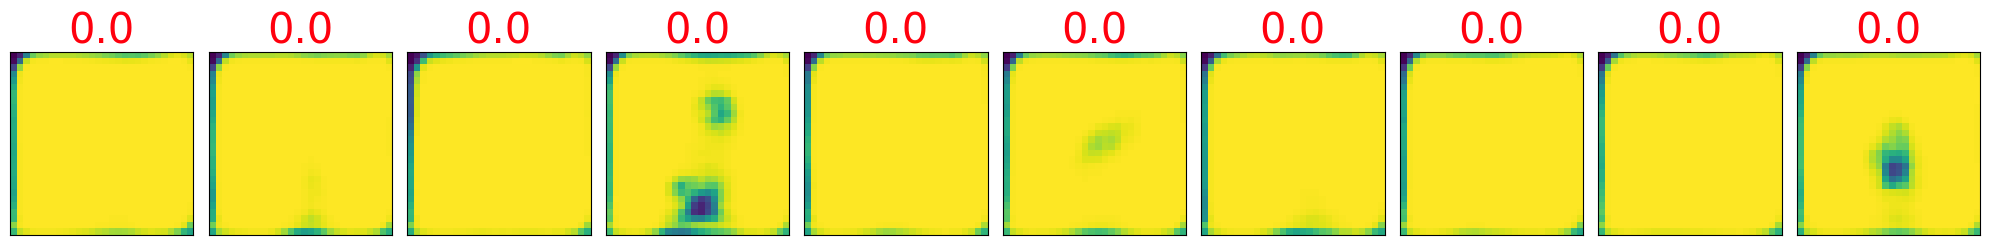

8/8 [==============================] - 0s 14ms/step
Iteration: 6/50{'verbose': 0, 'epochs': 1, 'steps': 4} /n
loss: 0.00217 accuracy: 1.00000 val_loss: 19.31780 val_accuracy: 0.00000 epochs: 19
Gen: 0.0
{'verbose': 0, 'epochs': 1, 'steps': 4} /n
loss: 0.00027 accuracy: 1.00000 val_loss: 19.32581 val_accuracy: 0.00000 epochs: 20
Gen: 0.0
{'verbose': 0, 'epochs': 1, 'steps': 4} /n
loss: 0.00074 accuracy: 1.00000 val_loss: 19.21665 val_accuracy: 0.00000 epochs: 21
Gen: 0.0
{'verbose': 0, 'epochs': 1, 'steps': 4} /n
loss: 0.00086 accuracy: 1.00000 val_loss: 19.25536 val_accuracy: 0.00000 epochs: 22
Gen: 0.0
{'verbose': 0, 'epochs': 1, 'steps': 4} /n
loss: 0.00698 accuracy: 0.99219 val_loss: 18.82722 val_accuracy: 0.00000 epochs: 23
Gen: 0.0
3/3 [==============================] - 0s 96ms/step
DISC:  loss: 0.00001 val_loss: 0.00000 epochs: 22
3/3 [==============================] - 0s 95ms/step
DISC:  loss: 0.00000 val_loss: 0.00000 epochs: 23
3/3 [==============================] - 0s 94ms/st

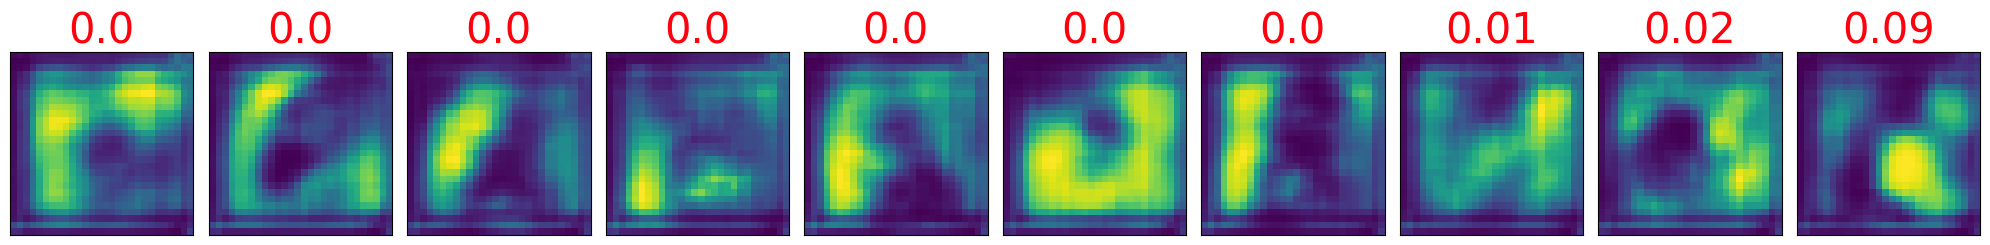

8/8 [==============================] - 0s 14ms/step
Iteration: 11/50{'verbose': 0, 'epochs': 1, 'steps': 4} /n
loss: 1.28071 accuracy: 0.67969 val_loss: 24.94855 val_accuracy: 0.00000 epochs: 41
Gen: 0.0
{'verbose': 0, 'epochs': 1, 'steps': 4} /n
loss: 0.69144 accuracy: 0.81250 val_loss: 8.78760 val_accuracy: 0.03125 epochs: 42
Gen: 0.03125
{'verbose': 0, 'epochs': 1, 'steps': 4} /n
loss: 0.49719 accuracy: 0.82031 val_loss: 11.10616 val_accuracy: 0.00000 epochs: 43
Gen: 0.0
{'verbose': 0, 'epochs': 1, 'steps': 4} /n
loss: 0.34913 accuracy: 0.89844 val_loss: 11.10553 val_accuracy: 0.00000 epochs: 44
Gen: 0.0
{'verbose': 0, 'epochs': 1, 'steps': 4} /n
loss: 0.14908 accuracy: 0.93750 val_loss: 10.81694 val_accuracy: 0.03125 epochs: 45
Gen: 0.03125
3/3 [==============================] - 0s 96ms/step
DISC:  loss: 0.02935 val_loss: 0.00709 epochs: 47
3/3 [==============================] - 0s 95ms/step
DISC:  loss: 0.04135 val_loss: 0.01420 epochs: 48
3/3 [==============================] - 0s

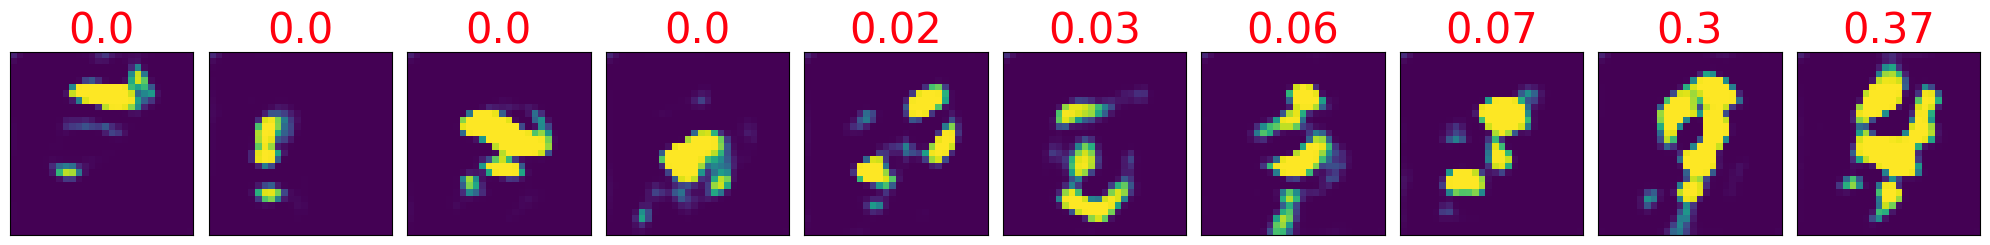

8/8 [==============================] - 0s 14ms/step
Iteration: 26/50{'verbose': 0, 'epochs': 1, 'steps': 4} /n
loss: 0.29819 accuracy: 0.89844 val_loss: 3.91233 val_accuracy: 0.00000 epochs: 103
Gen: 0.0
{'verbose': 0, 'epochs': 1, 'steps': 4} /n
loss: 0.23030 accuracy: 0.93750 val_loss: 4.61568 val_accuracy: 0.06250 epochs: 104
Gen: 0.0625
{'verbose': 0, 'epochs': 1, 'steps': 4} /n
loss: 0.24367 accuracy: 0.93750 val_loss: 3.67992 val_accuracy: 0.09375 epochs: 105
Gen: 0.09375
{'verbose': 0, 'epochs': 1, 'steps': 4} /n
loss: 0.25761 accuracy: 0.92188 val_loss: 2.18655 val_accuracy: 0.15625 epochs: 106
Gen: 0.15625
{'verbose': 0, 'epochs': 1, 'steps': 4} /n
loss: 0.17959 accuracy: 0.98438 val_loss: 2.42702 val_accuracy: 0.21875 epochs: 107
Gen: 0.21875
3/3 [==============================] - 0s 94ms/step
DISC:  loss: 0.32459 val_loss: 0.34338 epochs: 106
3/3 [==============================] - 0s 94ms/step
DISC:  loss: 0.30485 val_loss: 0.18040 epochs: 107
3/3 [==========================

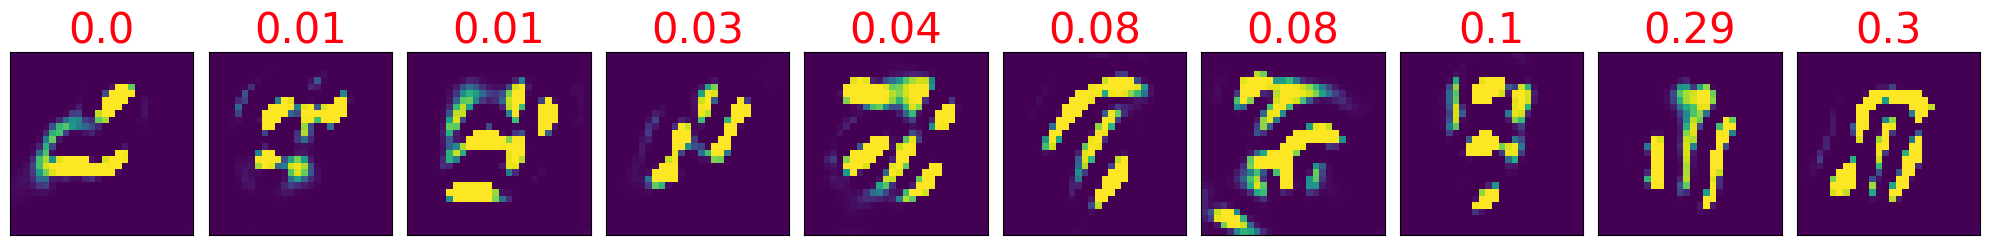

8/8 [==============================] - 0s 14ms/step


(<__main__.History at 0x300ee2e50>, <__main__.History at 0x2f23f1fd0>)

In [93]:
train(gan=gan, 
      num_iters=50, 
      epochs=5, 
      print_every=[1,2,3,5,10,25,50,100,200,300,500,1000,2000,3000,5000],
      save_example_name="5_epochs",
      save_model_name="gan",
      normal_noise=True)

8/8 [==============================] - 0s 15ms/step


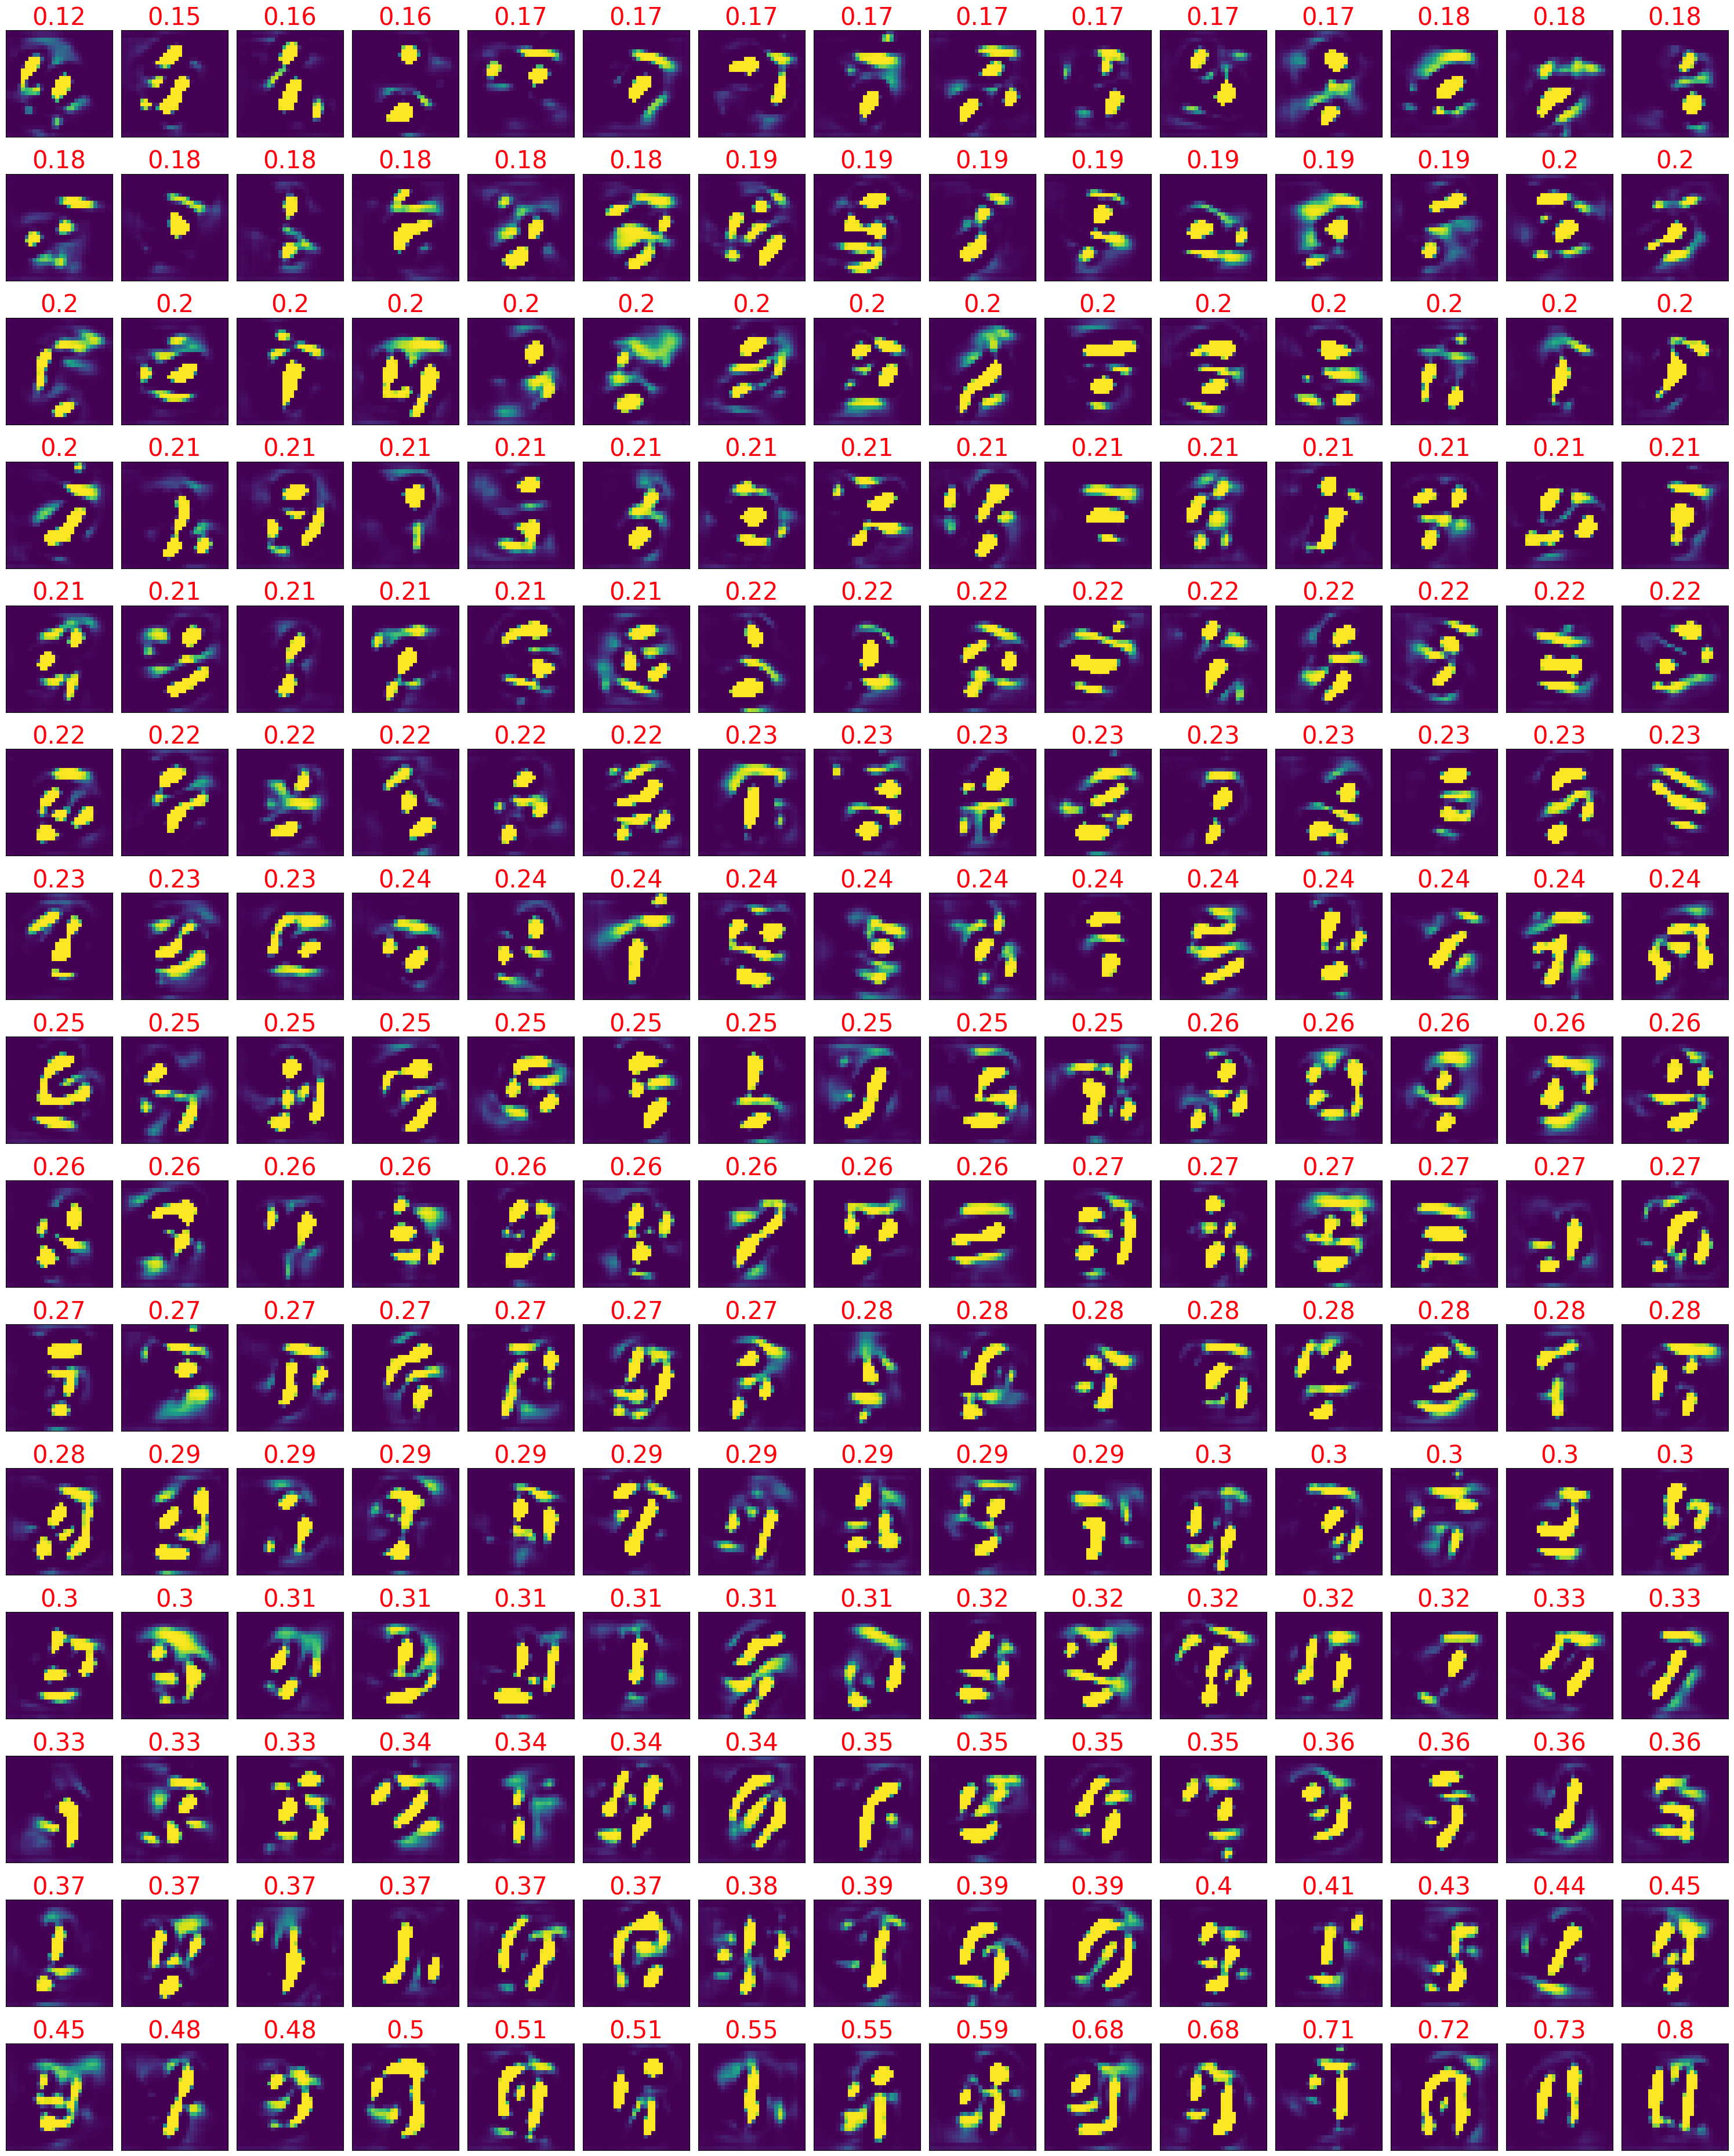

In [73]:
display_gen(gan, 15*15)

In [77]:
keras.utils.plot_model(gan, show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [82]:
g_val_loss = []
d_val_loss = []

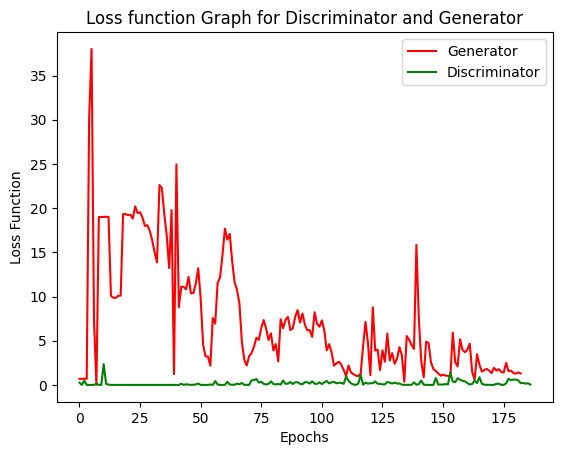

In [116]:
plt.plot(g_val_loss, 'red', label='Generator')
plt.plot(d_val_loss, 'green', label='Discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.legend()
plt.title("Loss function Graph for Discriminator and Generator")
plt.savefig('loss_function.png', format='png')
plt.show()

In [111]:
plt.savefig('loss_function.png', format='png')

<Figure size 640x480 with 0 Axes>